In [1]:

# Uncomment to download the packets
#!pip install matplotlib
#!pip install seaborn
#!pip install tqdm

In [2]:
# Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

# Set visualization style for the research notebook
sns.set_theme(style="whitegrid")

# Preamble

This simulation is run with the dataset1, which has been generated with the following parameters

| Parameter | Value | Meaning in the Simulation |
| :--- | :--- | :--- |
| **`N` (Sample Size)** | **250** | The total size of your dataset. Since you are simulating "Balanced" clusters, this means you will have exactly **125 points in Cluster A** and **125 points in Cluster B**. |
| **`p` (Variables)** | **2** | The number of dimensions ($X_1, X_2$). This is crucial because $p=2$ allows us to visualize the data easily on a 2D Scatter Plot. If $p$ were 10, the math works the same, but we couldn't see it easily. |
| **`rho` ($\rho$)** | **0.0** | The correlation between $X_1$ and $X_2$ *within* a cluster. <br>• **0.0:** The clusters are **Spherical** (round blobs). <br>• **0.9:** The clusters would be narrow, diagonal ellipses. |
| **`separation`** | **10** | The distance between the centers of the two clusters (in standard deviations). <br>• **10:** **Extremely Easy.** The clusters are far apart with zero overlap. <br>• **0.1:** **Impossible.** The clusters are on top of each other (pure noise). |
| **`k` (Clusters)** | **2** | The "Ground Truth." We *know* there are 2 groups. The goal of the simulation is to see if the clustering algorithm can figure this out looking only at the synthetic data. |
| **`method`** | **CART** | **C**lassification **A**nd **R**egression **T**rees. This is the algorithm used to create the synthetic data. It builds a decision tree to learn the rules of the real data and generates new points based on those rules. |
| **`m`** | **1** | We are generating a single synthetic dataset for this specific test. In the full simulation later, `m` will be 50 to get statistical averages. |


In [3]:
# ==========================================
# Configuration for Dataset 1
# ==========================================

# 1. Data Dimensions
N = 250            # Total number of observations (rows)
p = 2              # Number of variables/features (columns)

# 2. Cluster Properties
k = 2              # Number of clusters (groups)
rho = 0.0          # Correlation between variables (shape of cluster)
separation = 10    # Distance between cluster centroids (signal strength)

# 3. Synthesis Parameters
method = "CART"    # Method used to generate synthetic data
m = 1              # Number of synthetic datasets to generate

# K-Means Clustering

To replicate the RStudio results in Python, we first define the mechanics of the algorithm being used.

## Technical Definition
In technical terms, K-Means is an **iterative, unsupervised learning algorithm** that partitions a dataset into $k$ distinct, non-overlapping subgroups (clusters). It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster's centroid (arithmetic mean) is minimized.

## Conceptual Definition
Conceptually, K-Means organizes an unlabelled dataset by identifying natural groupings based on similarity. It operates like a sorting mechanism that organizes a mixed collection of items into distinct piles based on shared characteristics.

## Algorithmic Process: The "Pizza Delivery" Analogy
To understand the optimization process, consider a city map with 250 houses ($N=250$) where the goal is to build 2 pizza shops ($k=2$) that minimize the total delivery travel time for all residents.



1.  **Initialization:** Two pizza shops (centroids) are placed at random coordinates on the map.
2.  **Assignment:** Each house is assigned to the nearest pizza shop based on Euclidean distance. The city is now effectively divided into two zones (Voronoi cells).
3.  **Update (Centroids):** The location of each shop is recalculated. The shop is moved to the exact **geographic center** (mean $X_1, X_2$) of all the houses currently assigned to it.
4.  **Iteration:** Steps 2 and 3 are repeated. As the shops move to more central locations, the border between the two zones shifts, and some houses may be reassigned to a different shop.
5.  **Convergence:** The algorithm terminates when the shops no longer move (or movement is below a threshold), indicating that the optimal cluster centers have been found.

## Weaknesses and Assumptions
K-Means is a distance-based algorithm that assumes clusters are convex and isotropic (spherical). This has implications for the correlation parameter ($\rho$) in this study:

* **When $\rho = 0$:** The generated clusters are spherical. This is the ideal scenario for K-Means, and the algorithm is expected to perform optimally.
* **When $\rho \rightarrow 1$ (e.g., 0.9):** High correlation creates elongated, elliptical clusters ("cigar-shaped"). K-Means often struggles to separate these geometries correctly, as it relies purely on radial distance from a center point.



In [4]:
# Let's start by defining original and synthetic data paths.
ORIGINAL_DATA_PATH = "../data/1/original_data.csv"
SYNTHETIC_DATA_PATH = "../data/1/synthetic_data.csv"

# I will also fix now some parameters such as:
RND = 123
NUM_INIT = 100

In [5]:

# ==========================================
# 1. Gini Coefficient
# ==========================================
def gini_coefficient(x):
    """
    Calculate the Gini coefficient of a numpy array.
    Replicates the behavior of R's DescTools::Gini.
    """
    x = np.array(x, dtype=np.float64)
    if np.amin(x) < 0:
        x -= np.amin(x) # Ensure non-negative
    x += 0.0000001      # Avoid division by zero
    
    x = np.sort(x)
    n = x.shape[0]
    index = np.arange(1, n + 1)
    
    return ((np.sum((2 * index - n - 1) * x)) / (n * np.sum(x)))

# ==========================================
# 2. Optimal K Decision (The Decider)
# ==========================================
def get_optimal_k(data, max_k=10, RND=123):
    """
    Finds optimal k using Silhouette Score.
    Simulates the logic of fviz_nbclust.
    """
    best_score = -1
    best_k = 2
    best_model = None
    
    # Scale data (Crucial for K-Means distance calculation)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Iterate to find the k with the highest Silhouette Score
    for k in range(2, max_k + 1):
        km = KMeans(
                n_clusters=k,
                n_init=50,            # match R's nstart
                algorithm="lloyd",    # closest to R default
                max_iter=10,          # match R max iterations
                random_state=RND
            )
        labels = km.fit_predict(data_scaled)
        score = silhouette_score(data_scaled, labels)
        
        if score > best_score:
            best_score = score
            best_k = k
            best_model = km
            
    return best_k, best_model, data_scaled

# ==========================================
# 3. Label Switching (The Translator)
# ==========================================
def match_clusters(real_model, syn_model):
    """
    Matches synthetic labels to real labels using the Hungarian Algorithm
    on the centroids' Euclidean distances.
    """
    real_centers = real_model.cluster_centers_
    syn_centers = syn_model.cluster_centers_
    
    # Calculate distance matrix between all Real and Syn centroids
    dists = cdist(real_centers, syn_centers, metric='euclidean')
    
    # Solve the Linear Sum Assignment Problem (Hungarian Algo)
    # This finds the pairing that minimizes total distance
    real_indices, syn_indices = linear_sum_assignment(dists)
    
    # Create a map: {Synthetic_Label -> Real_Label}
    mapping = {syn_idx: real_idx for real_idx, syn_idx in zip(real_indices, syn_indices)}
    
    return mapping

In [6]:
# 1. Load Data
real_df = pd.read_csv(ORIGINAL_DATA_PATH)
syn_df = pd.read_csv(SYNTHETIC_DATA_PATH)

feature_cols = ['X1', 'X2']
X_real = real_df[feature_cols].copy()
X_syn = syn_df[feature_cols].copy()

# 2. Cluster REAL Data
real_k, real_model, real_scaled = get_optimal_k(X_real)
real_labels = real_model.labels_
real_counts = np.bincount(real_labels)

# 3. Cluster SYNTHETIC Data (Forcing k to match Real, per methodology)
# We use the scaler from the synthesis step to keep dimensions comparable
scaler = StandardScaler()
syn_scaled = scaler.fit_transform(X_syn)
syn_model = KMeans(n_clusters=real_k, n_init=NUM_INIT, random_state=RND)
syn_labels_raw = syn_model.fit_predict(syn_scaled)

# 4. Apply Label Switching
mapping = match_clusters(real_model, syn_model)
syn_labels_mapped = np.array([mapping[label] for label in syn_labels_raw])
syn_counts = np.bincount(syn_labels_mapped)

# 5. Calculate Metrics
metrics = {
    "Metric": ["Optimal k", "Gini Coeff", "Silhouette"],
    "Real Data": [
        real_k, 
        gini_coefficient(real_counts), 
        silhouette_score(real_scaled, real_labels)
    ],
    "Synthetic Data": [
        real_k, 
        gini_coefficient(syn_counts), 
        silhouette_score(syn_scaled, syn_labels_mapped)
    ]
}

# Display Results
results_df = pd.DataFrame(metrics)
results_df["Diff"] = results_df["Real Data"] - results_df["Synthetic Data"]
display(results_df)

,Metric,Real Data,Synthetic Data,Diff
0,Optimal k,2.000000,2.000000,0.000000
1,Gini Coeff,0.000000,0.020000,-0.020000
2,Silhouette,0.771373,0.786775,-0.015402


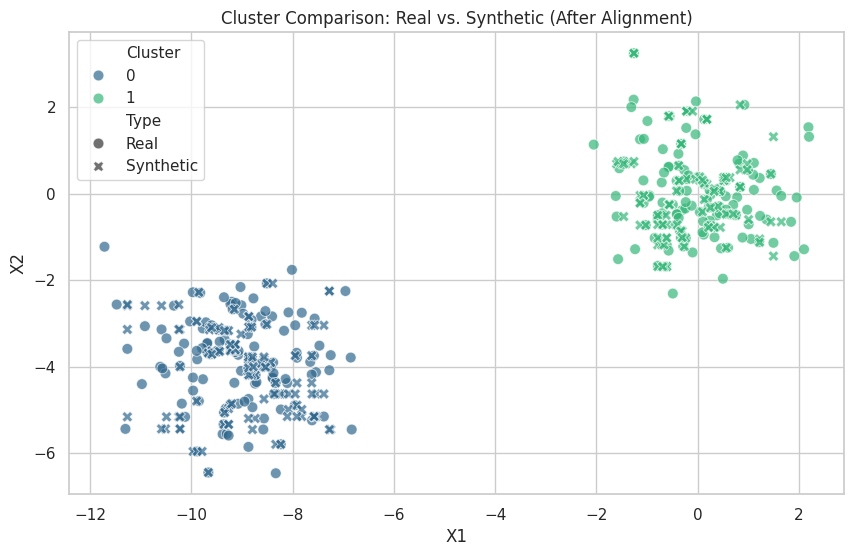

In [7]:
# Prepare data for plotting
plot_data = pd.concat([
    pd.DataFrame(X_real).assign(Cluster=real_labels, Type='Real'),
    pd.DataFrame(X_syn).assign(Cluster=syn_labels_mapped, Type='Synthetic')
])

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=plot_data, x='X1', y='X2', 
    hue='Cluster', style='Type', 
    palette='viridis', s=60, alpha=0.7
)
plt.title(f"Cluster Comparison: Real vs. Synthetic (After Alignment)")
plt.show()

In [8]:
# Ensure you have these imports
from joblib import Parallel, delayed
import pandas as pd
import time

# If you saved your generation functions in 'generate_and_save.py', import them:
# from generate_and_save import generate_original_data, generate_synthetic_cart
# OR, if they are defined in the notebook, just ensure this cell runs after them.

def simulate_one(params):
    """
    Worker function for parallel processing.
    Generates data, synthesizes it, and calculates metrics.
    """
    try:
        # 1. Unpack Parameters
        N, p, k = params['N'], params['p'], params['k']
        rho, sep = params['rho'], params['separation']
        seed = params['seed']
        
        # 2. Generate Data (Fresh for this seed)
        real_df = generate_original_data(N, p, rho, sep, k, seed=seed)
        
        # 3. Synthesize Data
        syn_df = generate_synthetic_cart(real_df, seed=seed)
        
        # 4. Prepare for Clustering (Drop labels)
        X_real = real_df.drop(columns=['group'])
        X_syn = syn_df.drop(columns=['group'])
        
        # 5. Cluster REAL Data (Find optimal k)
        # We scan k=2..5 to see if it finds the truth
        real_k_found, real_model, real_scaled = get_optimal_k(X_real, max_k=5, random_state=seed)
        
        # 6. Cluster SYNTHETIC Data
        # Force k to match what was found in Real data (mimicking 'k.real' from R)
        scaler = StandardScaler()
        syn_scaled = scaler.fit_transform(X_syn)
        
        syn_model = KMeans(
            n_clusters=k,
            n_init=50,            # match R's nstart
            algorithm="lloyd",    # closest to R default
            max_iter=10,          # match R max iterations
            random_state=RND
        )
        syn_labels_raw = syn_model.fit_predict(syn_scaled)
        
        # 7. Match Labels (Hungarian Algorithm)
        mapping = match_clusters(real_model, syn_model)
        syn_labels_mapped = np.array([mapping[label] for label in syn_labels_raw])
        
        # 8. Calculate Metrics
        # Real
        real_labels = real_model.labels_
        real_counts = np.bincount(real_labels)
        real_gini = gini_coefficient(real_counts)
        real_sil = silhouette_score(real_scaled, real_labels)
        
        # Synthetic
        syn_counts = np.bincount(syn_labels_mapped)
        syn_gini = gini_coefficient(syn_counts)
        syn_sil = silhouette_score(syn_scaled, syn_labels_mapped)
        
        # Success? (Did Real Data clustering find the correct k?)
        success = 1 if real_k_found == k else 0
        
        # 9. Return Result Row
        return {
            "N": N, "p": p, "k": k, "rho": rho, "separation": sep,
            "seed": seed,
            "k_found": real_k_found,
            "success": success,
            "Gini_Real": real_gini,
            "Gini_Syn": syn_gini,
            "Diff_Gini": real_gini - syn_gini,
            "Sil_Real": real_sil,
            "Sil_Syn": syn_sil,
            "Diff_Sil": real_sil - syn_sil
        }
        
    except Exception as e:
        # Handle crashes gracefully so the whole loop doesn't fail
        return {"error": str(e), **params}

In [9]:
# Define your experimental factors
N_list = [250]
p_list = [2, 5, 10]
k_list = [2, 3, 4]
rho_list = [0.0] # Add 0.5, 0.9 later if needed
separation_list = [0.1, 2, 6, 10]
n_simulations = 50 # Total 'm' per setting

# Create the grid of all jobs
param_grid = []

# Iterate through all combinations
import itertools

keys = ['N', 'p', 'k', 'rho', 'separation']
combinations = itertools.product(N_list, p_list, k_list, rho_list, separation_list)

for values in combinations:
    base_params = dict(zip(keys, values))
    
    # Add 50 seeds for each combination
    for i in range(n_simulations):
        # Create a unique seed for every single run to ensure randomness
        # e.g. seed = 1000 * iteration + i
        params = base_params.copy()
        params['seed'] = i + (hash(str(values)) % 100000) 
        params['method'] = 'CART'
        param_grid.append(params)

print(f"Total simulations to run: {len(param_grid)}")
# Expected: 1 (N) * 3 (p) * 3 (k) * 1 (rho) * 4 (sep) * 50 (m) = 1,800 jobs

Total simulations to run: 1800


🚀 Starting Simulation: 9000 iterations...


Processing: 100%|██████████| 9000/9000 [01:33<00:00, 96.02it/s] 



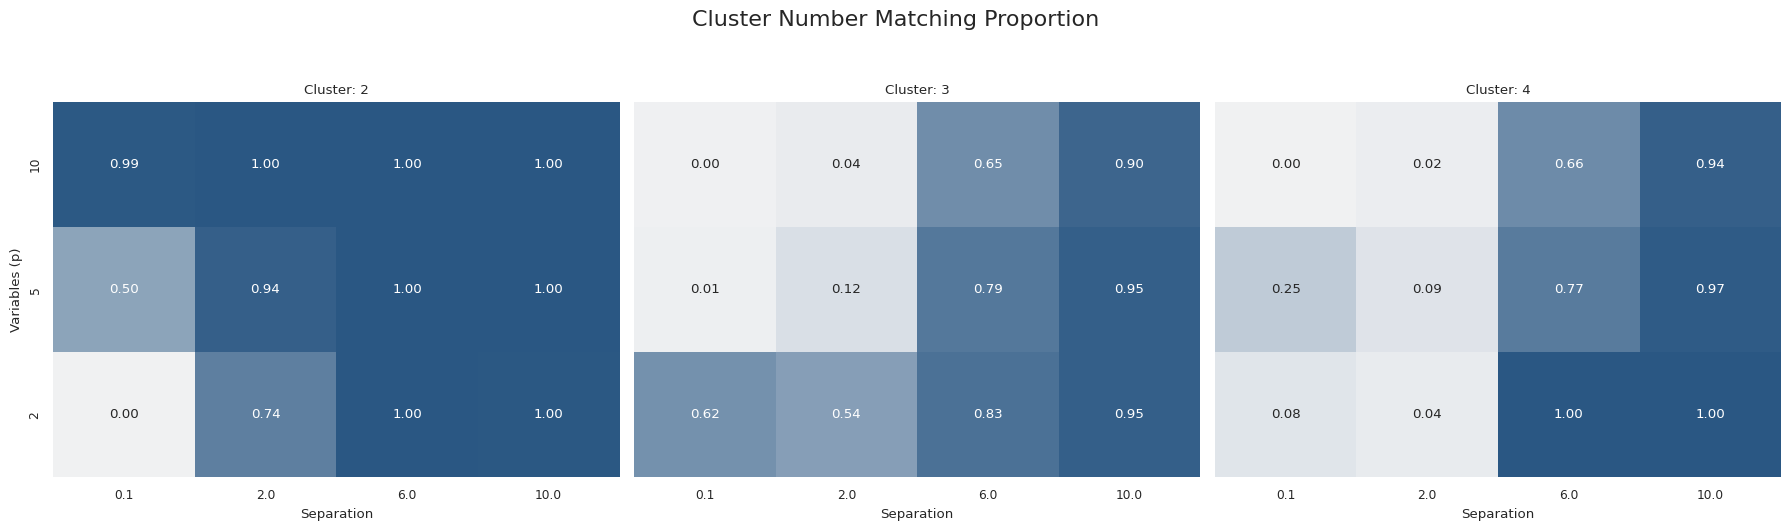

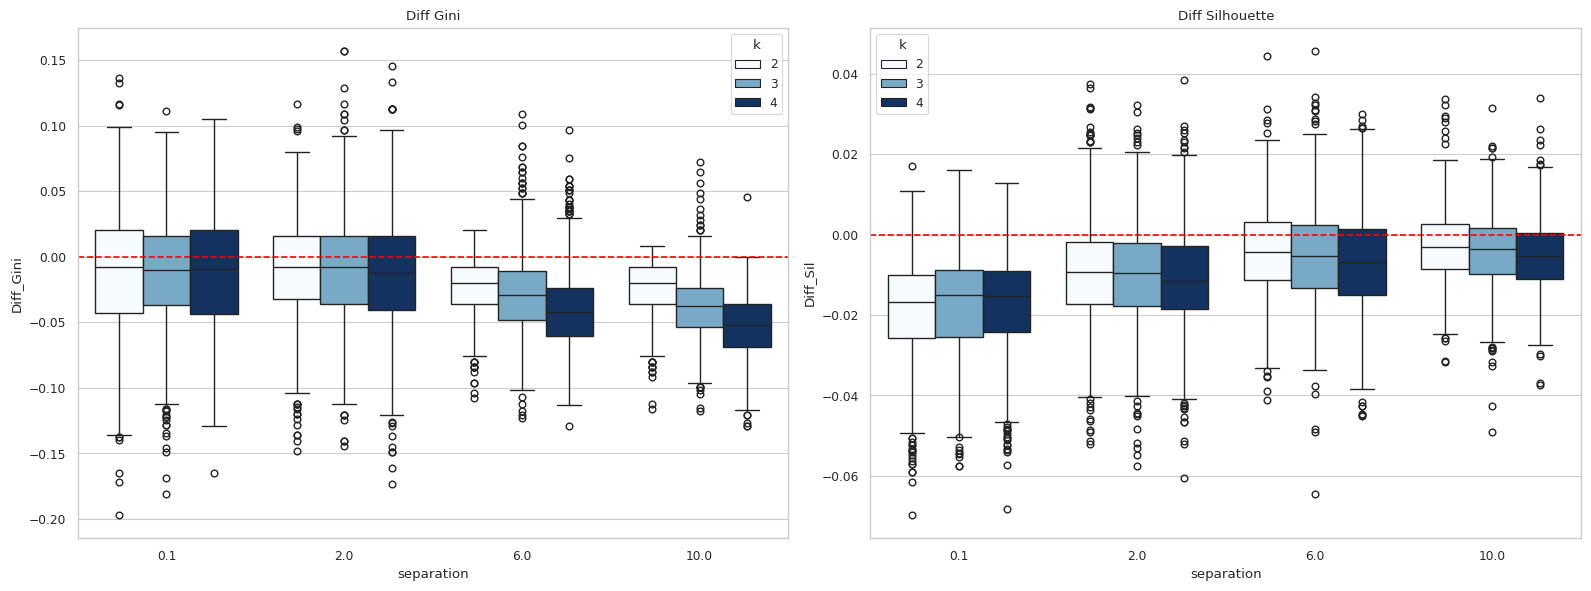

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import itertools

# Set plot style
sns.set_theme(style="whitegrid", context="paper")

# ==========================================
# 1. DEFINE HELPER FUNCTIONS (Required for Parallel Workers)
# ==========================================

def generate_centroids(k, p, separation):
    centroids = np.zeros((k, p))
    centroids[0, :] = 0 
    for i in range(1, k):
        tries = 0
        while True:
            vector = np.random.normal(0, 1, p)
            vector = (vector / np.linalg.norm(vector)) * separation
            dists = np.linalg.norm(centroids[:i, :] - vector, axis=1)
            if np.all(dists >= separation):
                centroids[i, :] = vector
                break
            tries += 1
            if tries > 1000: raise ValueError("Could not generate separated centroids.")
    return centroids

def generate_original_data(N, p, rho, separation, k, seed=None):
    if seed: np.random.seed(seed)
    centroids = generate_centroids(k, p, separation)
    R = np.full((p, p), rho)
    np.fill_diagonal(R, 1)
    data_list = []
    n_per_cluster = round(N / k)
    for i in range(k):
        cluster_data = multivariate_normal.rvs(mean=centroids[i], cov=R, size=n_per_cluster)
        if p == 1: cluster_data = cluster_data.reshape(-1, 1)
        df = pd.DataFrame(cluster_data, columns=[f'X{j+1}' for j in range(p)])
        df['group'] = i + 1
        data_list.append(df)
    return pd.concat(data_list, ignore_index=True)

def generate_synthetic_cart(real_data, seed=None):
    if seed: np.random.seed(seed)
    data_to_synth = real_data.drop(columns=['group'])
    n_rows, n_cols = data_to_synth.shape
    syn_data = pd.DataFrame(index=range(n_rows), columns=data_to_synth.columns)
    
    first_col = data_to_synth.columns[0]
    syn_data[first_col] = np.random.choice(data_to_synth[first_col], size=n_rows, replace=True)
    
    for i in range(1, n_cols):
        target = data_to_synth.columns[i]
        features = data_to_synth.columns[:i]
        tree = DecisionTreeRegressor(random_state=seed)
        tree.fit(data_to_synth[features], data_to_synth[target])
        pred = tree.predict(syn_data[features])
        residuals = data_to_synth[target] - tree.predict(data_to_synth[features])
        noise = np.random.choice(residuals, size=n_rows, replace=True)
        syn_data[target] = pred + noise
    
    syn_data['group'] = real_data['group'].values
    return syn_data

def gini_coefficient(x):
    x = np.array(x, dtype=np.float64)
    if np.amin(x) < 0: x -= np.amin(x)
    x += 0.0000001
    x = np.sort(x)
    n = x.shape[0]
    index = np.arange(1, n + 1)
    return ((np.sum((2 * index - n - 1) * x)) / (n * np.sum(x)))

def get_optimal_k(data, max_k=10, random_state=123):
    best_score = -1
    best_k = 2
    best_model = None
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    for k in range(2, max_k + 1):
        km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels = km.fit_predict(data_scaled)
        score = silhouette_score(data_scaled, labels)
        if score > best_score:
            best_score = score
            best_k = k
            best_model = km
    return best_k, best_model, data_scaled

def match_clusters(real_model, syn_model):
    real_centers = real_model.cluster_centers_
    syn_centers = syn_model.cluster_centers_
    dists = cdist(real_centers, syn_centers, metric='euclidean')
    real_indices, syn_indices = linear_sum_assignment(dists)
    mapping = {syn_idx: real_idx for real_idx, syn_idx in zip(real_indices, syn_indices)}
    return mapping

def simulate_one(params):
    try:
        N, p, k = params['N'], params['p'], params['k']
        rho, sep = params['rho'], params['separation']
        seed = params['seed']
        
        # Generate
        real_df = generate_original_data(N, p, rho, sep, k, seed=seed)
        syn_df = generate_synthetic_cart(real_df, seed=seed)
        
        X_real = real_df.drop(columns=['group'])
        X_syn = syn_df.drop(columns=['group'])
        
        # Cluster Real
        real_k_found, real_model, real_scaled = get_optimal_k(X_real, max_k=5, random_state=seed)
        
        # Cluster Syn (Force k)
        scaler = StandardScaler()
        syn_scaled = scaler.fit_transform(X_syn)
        syn_model = KMeans(n_clusters=real_k_found, n_init=10, random_state=seed)
        syn_labels_raw = syn_model.fit_predict(syn_scaled)
        
        # Match
        mapping = match_clusters(real_model, syn_model)
        syn_labels_mapped = np.array([mapping[label] for label in syn_labels_raw])
        
        # Metrics
        real_labels = real_model.labels_
        real_counts = np.bincount(real_labels)
        real_gini = gini_coefficient(real_counts)
        real_sil = silhouette_score(real_scaled, real_labels)
        
        syn_counts = np.bincount(syn_labels_mapped)
        syn_gini = gini_coefficient(syn_counts)
        syn_sil = silhouette_score(syn_scaled, syn_labels_mapped)
        
        success = 1 if real_k_found == k else 0
        
        return {
            "N": N, "p": p, "k": k, "rho": rho, "separation": sep,
            "seed": seed,
            "k_found": real_k_found,
            "success": success,
            "Gini_Real": real_gini,
            "Gini_Syn": syn_gini,
            "Diff_Gini": real_gini - syn_gini,
            "Sil_Real": real_sil,
            "Sil_Syn": syn_sil,
            "Diff_Sil": real_sil - syn_sil
        }
    except Exception as e:
        return {"error": str(e), **params}

# ==========================================
# 2. RUN SIMULATION
# ==========================================
N_list = [250]
p_list = [2, 5, 10]
k_list = [2, 3, 4]
rho_list = [0.0]
separation_list = [0.1, 2, 6, 10]
n_simulations = 250 

keys = ['N', 'p', 'k', 'rho', 'separation']
combinations = itertools.product(N_list, p_list, k_list, rho_list, separation_list)

param_grid = []
for values in combinations:
    base_params = dict(zip(keys, values))
    for i in range(n_simulations):
        params = base_params.copy()
        params['seed'] = i + (hash(str(values)) % 100000)
        params['method'] = 'CART'
        param_grid.append(params)

print(f"🚀 Starting Simulation: {len(param_grid)} iterations...")

# Run Parallel
results_list = Parallel(n_jobs=-1)(
    delayed(simulate_one)(params) for params in tqdm(param_grid, desc="Processing")
)

df_results = pd.DataFrame(results_list)

# Check for errors
if 'error' in df_results.columns:
    failed = df_results[df_results['error'].notna()]
    if not failed.empty:
        print(f"⚠️ {len(failed)} failed. Example: {failed.iloc[0]['error']}")
        df_results = df_results.dropna(subset=['success'])

# ==========================================
# 3. VISUALIZATION
# ==========================================
if not df_results.empty:
    # Heatmap
    df_summary = df_results.groupby(['k', 'p', 'separation'])['success'].mean().reset_index()
    k_values = sorted(df_summary['k'].unique())
    fig, axes = plt.subplots(1, len(k_values), figsize=(18, 5), sharey=True)
    cmap = sns.light_palette("#2A5783", as_cmap=True)

    for i, k_val in enumerate(k_values):
        data_k = df_summary[df_summary['k'] == k_val]
        heatmap_data = data_k.pivot(index="p", columns="separation", values="success")
        heatmap_data = heatmap_data.sort_index(ascending=False) 
        sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap=cmap, vmin=0, vmax=1, ax=axes[i], cbar=False)
        axes[i].set_title(f"Cluster: {k_val}")
        axes[i].set_xlabel("Separation")
        if i == 0: axes[i].set_ylabel("Variables (p)")
        else: axes[i].set_ylabel("")

    plt.suptitle("Cluster Number Matching Proportion", y=1.05, fontsize=16)
    plt.tight_layout()
    plt.show()

    # Boxplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.boxplot(data=df_results, x="separation", y="Diff_Gini", hue="k", palette="Blues", ax=axes[0])
    axes[0].set_title("Diff Gini")
    axes[0].axhline(0, color='red', linestyle='--')

    sns.boxplot(data=df_results, x="separation", y="Diff_Sil", hue="k", palette="Blues", ax=axes[1])
    axes[1].set_title("Diff Silhouette")
    axes[1].axhline(0, color='red', linestyle='--')
    plt.tight_layout()
    plt.show()